In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
def find_points(img_path):
    nx=9
    ny=6
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    return ret,corners


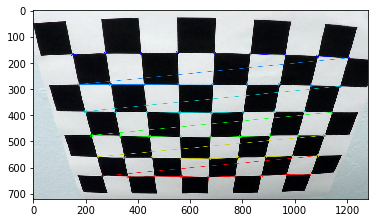

In [3]:
#find_points('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
img=cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration2.jpg')
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
cv2.drawChessboardCorners(img, (9, 6), corners, ret)
plt.imshow(img)

In [20]:
gray.shape[::-1]

(1280, 720)

In [4]:
def find_points_all_images(dir):
    img_paths=glob.glob(dir + '/' + '*.jpg')
    img_points=[]
    obj_points=[]
    objp=np.zeros((6*9,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    for img_path in img_paths:
        ret,corners = find_points(img_path)
       
        if ret:
            obj_points.append(objp)
            img_points.append(corners)
    return obj_points,img_points
        
    

In [5]:
obj_points,img_points = find_points_all_images('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal')

In [6]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(obj_points,img_points,(1280,720),None,None)

In [7]:
undistorted_image = cv2.undistort(cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'),mtx,dist,None,mtx)

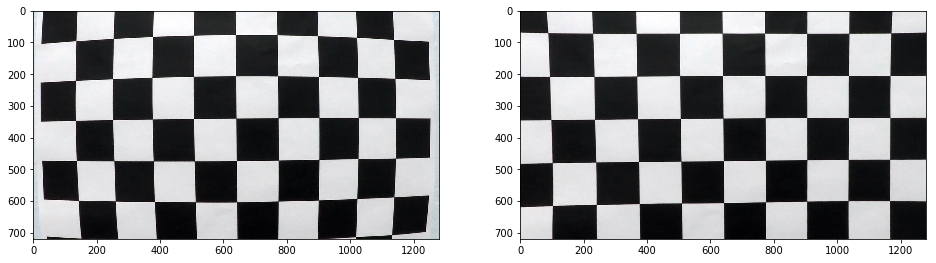

In [12]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'))
plt.subplot(1,2,2)
plt.imshow(undistorted_image)

In [13]:
def undistort_image(img):
    return cv2.undistort(img,mtx,dist,None,mtx)

In [14]:
#from lecture_notes
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255,sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)) 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output
    

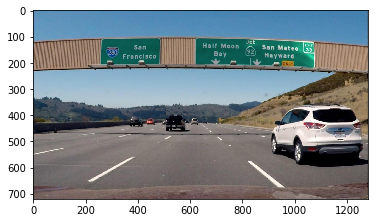

In [15]:
test_image=cv2.imread('/home/carnd/self-driving/advanced-lane-finding/signs_vehicles_xygrad.png')
plt.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))

In [ ]:
#play around a little with thresholds to see the impact

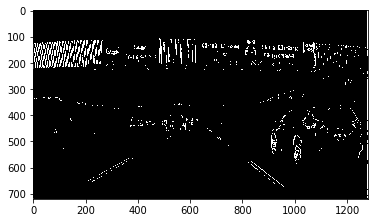

In [61]:
binary_image=abs_sobel_thresh(test_image,thresh_min=45, thresh_max=150)
plt.imshow(binary_image,cmap='gray')

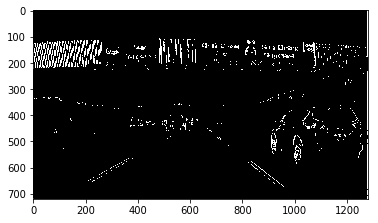

In [50]:
binary_image=abs_sobel_thresh(test_image,thresh_min=45, thresh_max=200)
plt.imshow(binary_image,cmap='gray')

In [16]:
# from lecture notes
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

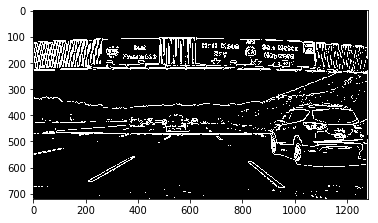

In [51]:
binary_image = mag_thresh(test_image,mag_thresh=(30,200))
plt.imshow(binary_image,cmap='gray')
# not much can be gleaned from just mag_thresh..only a combination with direction can generate useful results

In [17]:
#from lecture notes
def direction_threshold(img,sobel_kernel=3,thresh=(0,np.pi/2.0)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
    

In [18]:
def mag_and_dir(img,sobel_kernel=3,mag_threshold=(30,150),dir_thresh=(0.7,1.3)):
    mag_binary=mag_thresh(img,sobel_kernel=sobel_kernel,mag_thresh=mag_threshold)
    dir_binary=direction_threshold(img,sobel_kernel=sobel_kernel,thresh=dir_thresh)
    composite_binary = np.zeros_like(dir_binary)
    composite_binary[(mag_binary==1) &(dir_binary==1) ]=1
    return composite_binary


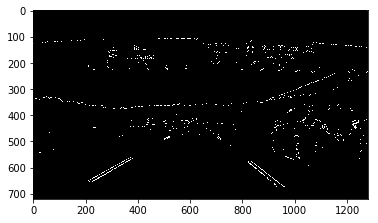

In [19]:
binary_image=mag_and_dir(test_image,mag_threshold=(45,200),dir_thresh=(0.7,1.3))
plt.imshow(binary_image,cmap='gray')

In [22]:
def compose_all_gray_gradients(img,sobel_kernel=3):
    gradx = abs_sobel_thresh(img,orient='x',thresh_min=30,thresh_max=150,sobel_kernel=sobel_kernel)
    grady = abs_sobel_thresh(img,orient='y',thresh_min=30,thresh_max=150,sobel_kernel=sobel_kernel)
    mag_and_dir_binary = mag_and_dir(img,mag_threshold=(45,200),
                                     dir_thresh=(0.7,1.3),sobel_kernel=sobel_kernel)
    final_binary = np.zeros_like(gradx)
    final_binary[((gradx==1) & (grady==1)) |(mag_and_dir_binary==1)]=1
    return final_binary

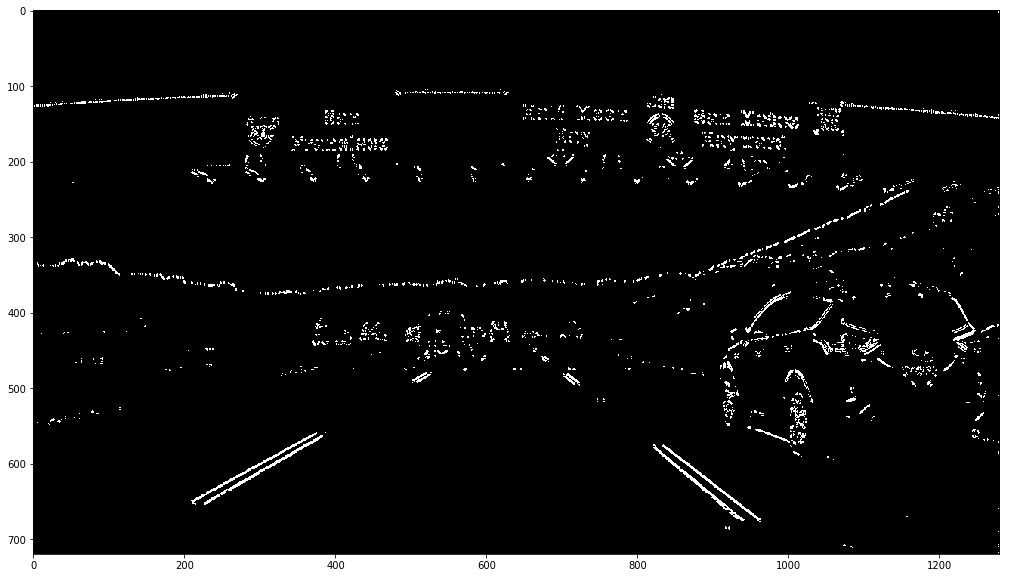

In [23]:
binary_image=compose_all_gray_gradients(test_image,sobel_kernel=5)
plt.figure(figsize=(20,10))
plt.imshow(binary_image,cmap='gray')

In [24]:
def color_gray_gradient_threshold(img,min_threshold,max_threshold):
    hls_image = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    #gray_grad=abs_sobel_thresh(img,orient='x',thresh_min=30,thresh_max=150)
    gray_grad = compose_all_gray_gradients(img,sobel_kernel=5)
    s_channel=hls_image[:,:,2]
    binary_output = np.zeros_like(gray_grad)
    binary_output[(gray_grad==1) | ((s_channel<max_threshold) & (s_channel>min_threshold)) ]=1
    return binary_output

In [ ]:
binary_image=color_gray_gradient_threshold(test_image,170,255)
plt.figure(figsize=(20,10))
plt.imshow(binary_image,cmap='gray')

In [70]:
def perspective_transform(img):
    offset = 300
    src = np.float32([[521,504],[769,504],[1056,687],[254,687]])
    dst = np.float32([[300,0],[900,0],[900,700],[300,700]])
    M = cv2.getPerspectiveTransform(src,dst)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped
    

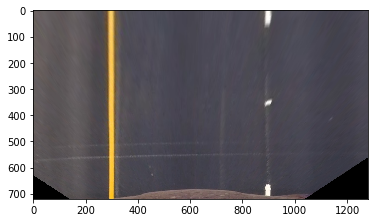

In [71]:
test_image=cv2.imread('/home/carnd/self-driving/advanced-lane-finding/straight_lines1.jpg')
t=perspective_transform(undistort_image(test_image))
t=cv2.cvtColor(t,cv2.COLOR_BGR2RGB)
plt.imshow(t)

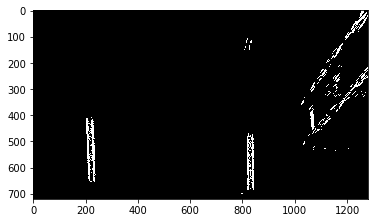

In [75]:
t=perspective_transform(binary_image)
#t=cv2.cvtColor(t,cv2.COLOR_BGR2RGB)
plt.imshow(t,cmap='gray')